CARND - Traffic Sign Classification Project
==================================
German traffic sign classification  as a part of the Self-driving Car Nanodegree program at Udacity using LeNet architecture.

-----------
### Step 0: Load the data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import math

from src import loading, utils, lenet, preprocessing, augmentation
from sklearn.utils import shuffle
logger = utils.get_logger('Main Notebook')

In [2]:
training, validation, test = loading.load_all()

-------
### Step 1: Dataset Summary & Exploration

Task: provide a basic summary of the dataset, including an exploratory visualisation of the data set.

In [3]:
summary = utils.get_summary([training, validation, test])
print(summary)

{'VALIDATION': {'no-of-classes': 43, 'image-shape': (32, 32, 3), 'number-of-examples': 4410}, 'total-no-of-classes': 43, 'TRAINING': {'no-of-classes': 43, 'image-shape': (32, 32, 3), 'number-of-examples': 34799}, 'TEST': {'no-of-classes': 43, 'image-shape': (32, 32, 3), 'number-of-examples': 12630}}


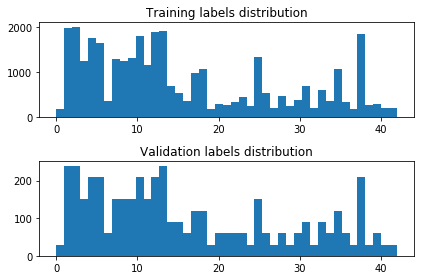

In [4]:
plt.subplot(211)
plt.hist(training.y, bins=summary['total-no-of-classes']);
plt.title('Training labels distribution');

plt.subplot(212)
plt.hist(validation.y, bins=summary['total-no-of-classes']);
plt.title('Validation labels distribution');
plt.tight_layout()
plt.savefig('./docs/images/training-validation-histogram.jpg')

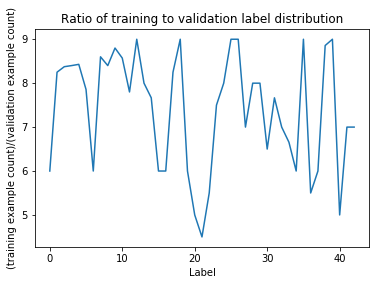

In [5]:
# Show that training/validation is somehow balanced
y_train_counts = utils.group_labels_by_counts(training)
y_validation_counts = utils.group_labels_by_counts(validation)
plt.plot(y_train_counts['counts']/ y_validation_counts['counts']);
plt.title('Ratio of training to validation label distribution');
plt.xlabel('Label');
plt.ylabel('(training example count)/(validation example count)');
plt.savefig('./docs/images/training-validation-sample-size-ratios.jpg')

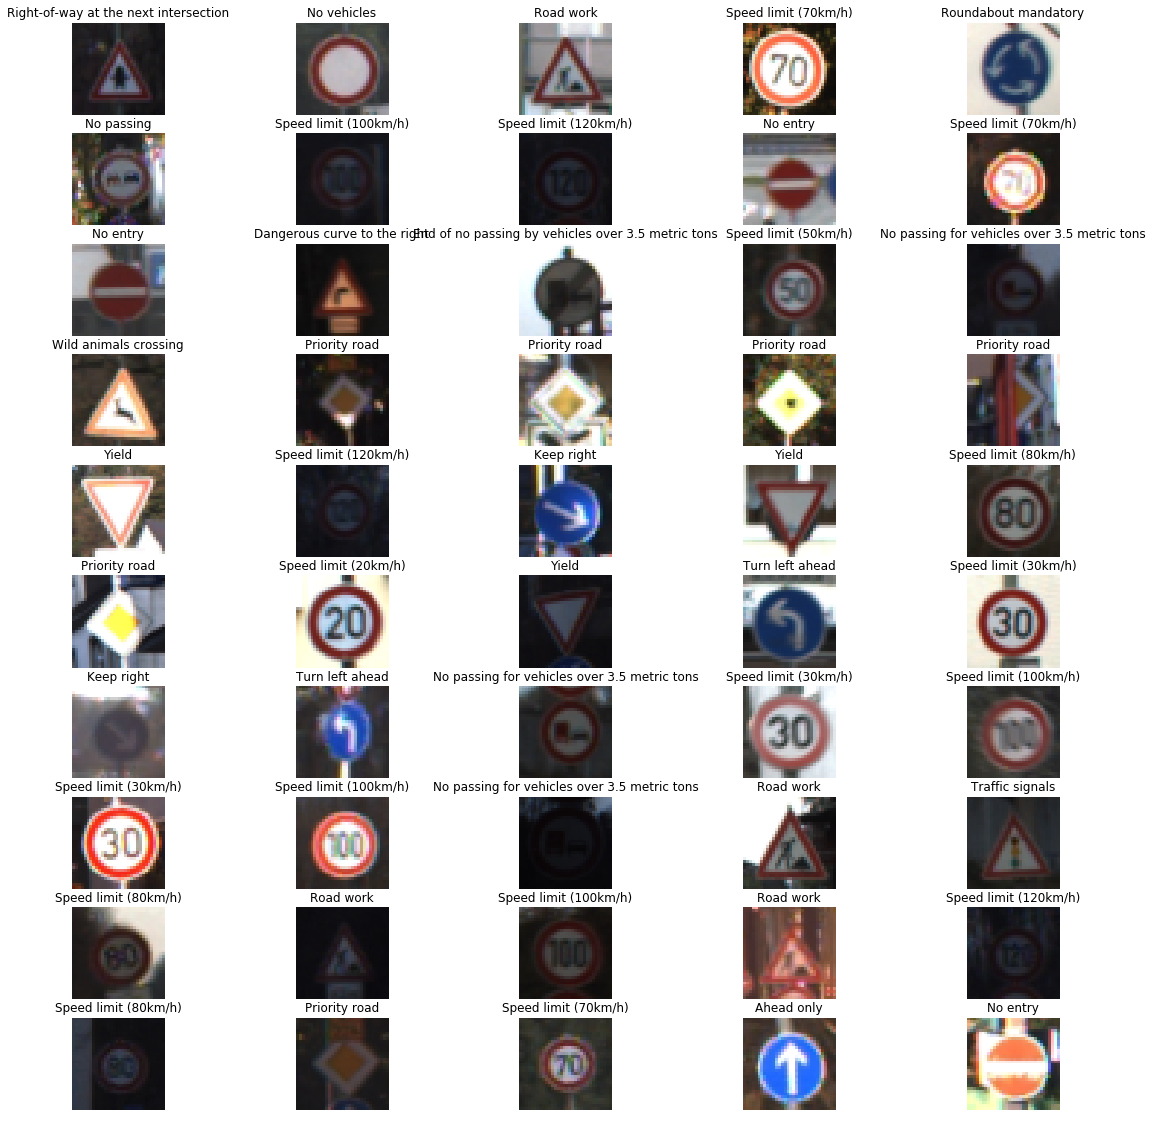

In [27]:
images = []
labels = []
for i in range(50):
    index = random.randint(0, training.count)
    images.append(training.X[index])
    labels.append(utils.to_sign_label(training.y[index]))
utils.plot_and_save(images, labels, './docs/images/25-random-images.jpg', 5)

['No passing for vehicles over 3.5 metric tons', 'Keep right', 'Yield', 'Roundabout mandatory']


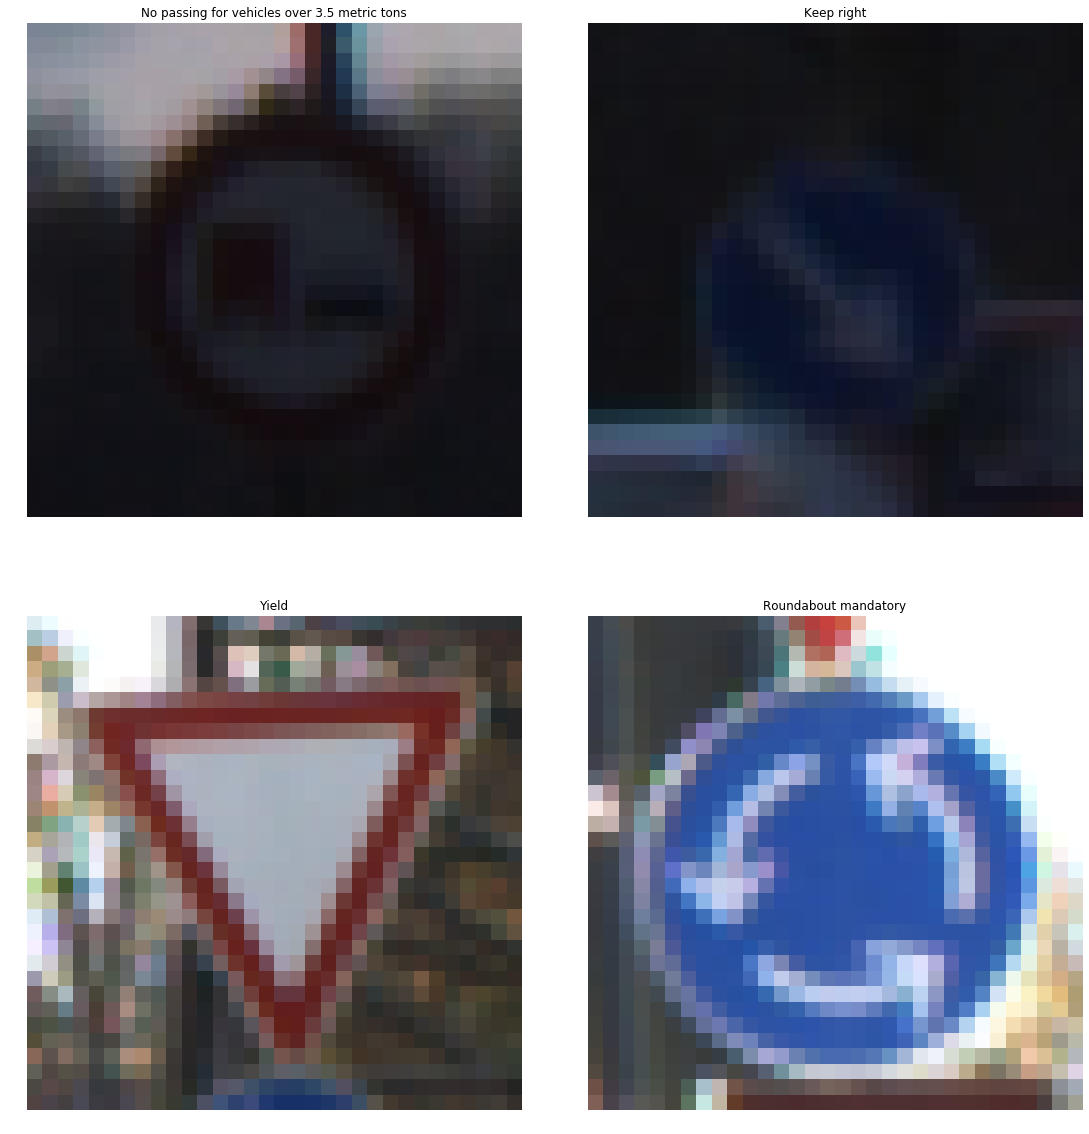

In [26]:
example_images = {
    'with bad lighting': [17894, 14044],
    'good': [22842, 4220]
}
images = []
labels = []
for label, indices in example_images.items():
    for i in indices:
        images.append(training.X[i])
        labels.append(utils.to_sign_label(training.y[i]))

print(labels)
utils.plot_and_save(images, labels, 'docs/images/cherry-pick-good-bad-images.jpg', 2)

----

## Step 2: Design and Test a Model Architecture

#### Pre-process and augment dataset

In [16]:
# List of enable data augmenters
TRAINING_DATA_AUGMENTERS = [
    augmentation.HorizontalFlipper(),
    augmentation.AffineTransformAugmenter(),
    augmentation.GaussianBlurAugmenter()
]
print('Original: ', utils.get_summary([training]))
d_train = preprocessing.PreProcessor.apply(training, TRAINING_DATA_AUGMENTERS)
print('Augmented: ', utils.get_summary([d_train]))

Original:  {'TRAINING': {'no-of-classes': 43, 'image-shape': (32, 32, 3), 'number-of-examples': 34799}, 'total-no-of-classes': 43}
2019-03-08 14:40:16 INFO     Running HORIZONTAL_FLIPPER on TRAINING dataset...
2019-03-08 14:40:16 INFO     	Parameters: {"PIXELS": 4}
2019-03-08 14:40:17 INFO     Running AFFINE_TRANSFORM_AUGMENTER on TRAINING dataset...
2019-03-08 14:40:17 INFO     	Parameters: {"PIXELS": 4}
2019-03-08 14:40:22 INFO     Running GAUSSIAN_BLUR on TRAINING dataset...
2019-03-08 14:40:22 INFO     	Parameters: {"ksize": [3, 3], "sigma": 0}
Augmented:  {'TRAINING': {'no-of-classes': 43, 'image-shape': (32, 32, 3), 'number-of-examples': 34799}, 'total-no-of-classes': 43}


In [17]:
# List of enabled data-preprocessors
PRE_PROCESSORS = [
    preprocessing.GrayScaleConverter(),
    preprocessing.ZNormaliser(),
]
# Perform pre-processing on augmented training, validation and test dataset

d_train = preprocessing.PreProcessor.apply(d_train, PRE_PROCESSORS)
d_validation = preprocessing.PreProcessor.apply(validation, PRE_PROCESSORS)

2019-03-08 14:40:46 INFO     Running TO_GRAY_SCALE on TRAINING dataset...
2019-03-08 14:40:46 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-08 14:41:23 INFO     Running Z_NORMALISATION on TRAINING dataset...
2019-03-08 14:41:23 INFO     	Parameters: null
2019-03-08 14:41:23 INFO     No means were calculated yet. Using score and mean from TRAINING...
2019-03-08 14:41:39 INFO     Normalising TRAINING with mean: 77.21783014595798 and sigma: 65.04807293878758...
2019-03-08 14:41:42 INFO     Running TO_GRAY_SCALE on VALIDATION dataset...
2019-03-08 14:41:42 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-08 14:41:42 INFO     Running Z_NORMALISATION on VALIDATION dataset...
2019-03-08 14:41:42 INFO     	Parameters: null
2019-03-08 14:41:42 INFO     Normalising VALIDATION with mean: 77.21783014595798 and sigma: 65.04807293878758...


2019-03-08 15:21:23 INFO     Running TO_GRAY_SCALE on bad_samples dataset...
2019-03-08 15:21:23 INFO     Running TO_GRAY_SCALE on bad_samples dataset...
2019-03-08 15:21:23 INFO     Running TO_GRAY_SCALE on bad_samples dataset...
2019-03-08 15:21:23 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-08 15:21:23 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-08 15:21:23 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-08 15:21:23 INFO     Running Z_NORMALISATION on bad_samples dataset...
2019-03-08 15:21:23 INFO     Running Z_NORMALISATION on bad_samples dataset...
2019-03-08 15:21:23 INFO     Running Z_NORMALISATION on bad_samples dataset...
2019-03-08 15:21:23 INFO     	Parameters: null
2019-03-08 15:21:23 INFO     	Parameters: null
2019-03-08 15:21:23 INFO     	Parameters: null
2019-03-08 15:21:23 INFO     Normalising bad_samples with mean: 77.21783014595798 and sigma: 65.04807293878758...


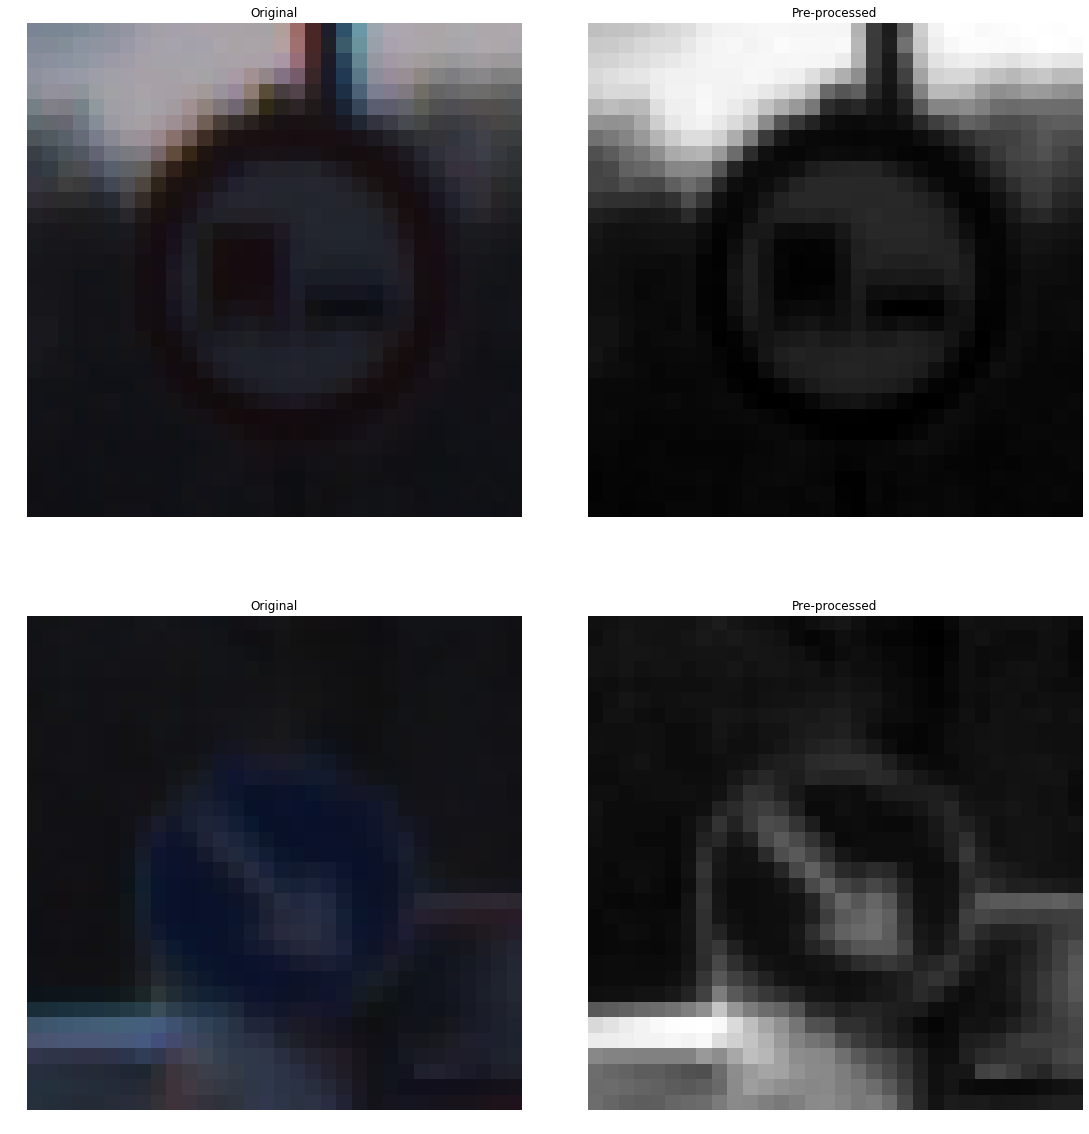

In [41]:
# Apply pre-processing to two of the "bad" images
BAD_IMAGE_INDEX = [17894, 14044]

bad_x = np.zeros((2, 32, 32, 3))
bad_y = np.zeros(2,)
for i in range(len(BAD_IMAGE_INDEX)):
    bad_x[i,:] = training.X[BAD_IMAGE_INDEX[i]]
    bad_y[i] = training.y[BAD_IMAGE_INDEX[i]]
bad_examples = loading.DataSet('bad_samples', bad_x, bad_y, len(bad_x))

pre_processed = preprocessing.PreProcessor.apply(bad_examples, PRE_PROCESSORS)

images = []
labels = []
for i in range(len(BAD_IMAGE_INDEX)):
    images.append(training.X[BAD_IMAGE_INDEX[i]]);
    labels.append('Original')

    images.append(pre_processed.X[i].squeeze());
    labels.append('Pre-processed')
utils.plot_and_save(images, labels, './docs/images/bad-images-pre-processed.jpg', 2)

#### Initialize Placeholders and setup computation graph

In [35]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
mode = tf.placeholder(tf.string, (None))

training_operation, accuracy_operation, logits = lenet.setup_graph(x, y, mode)

2019-03-08 15:07:36 INFO     Running LeNet in Tensor("Placeholder_2:0", dtype=string) mode with keep probability of Tensor("cond/Merge:0", shape=(), dtype=float32)...


#### Start training

In [36]:
from src.lenet import HYPER_PARAMETERS, Mode
logger.info('Hyper-parameters: %s', HYPER_PARAMETERS)

# TODO: this override is just for local testing - remove it in the final version
HYPER_PARAMETERS['EPOCHS'] = 1

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = d_train.count

    logger.info("Training...")
    for i in range(HYPER_PARAMETERS['EPOCHS']):
        X_train, y_train = shuffle(d_train.X, d_train.y)
        training_accuracy = 0
        for offset in range(0, num_examples, HYPER_PARAMETERS['BATCH_SIZE']):
            end = offset + HYPER_PARAMETERS['BATCH_SIZE']
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, mode: Mode.TRAINING.value})

        training_accuracy = lenet.evaluation(d_train.X, d_train.y, x, y, mode, accuracy_operation)
        validation_accuracy = lenet.evaluation(d_validation.X, d_validation.y, x, y, mode, accuracy_operation)
        logger.info("EPOCH {} ...".format(i + 1))
        logger.info("Accuracy on training dataset = {:.3f}".format(training_accuracy))
        logger.info("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './data/model/lenet')
    logger.info("Model saved")



2019-03-08 15:07:41 INFO     Hyper-parameters: {'mu': 0, 'sigma': 0.1, 'LEARNING_RATE': 0.001, 'KEEP_PROBABILITY_DURING_TRAINING': 0.7, 'BATCH_SIZE': 128, 'EPOCHS': 1}
2019-03-08 15:07:41 INFO     Training...
2019-03-08 15:15:02 INFO     EPOCH 1 ...
2019-03-08 15:15:02 INFO     Accuracy on training dataset = 0.492
2019-03-08 15:15:02 INFO     Validation Accuracy = 0.551

2019-03-08 15:15:02 INFO     Model saved


---
## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

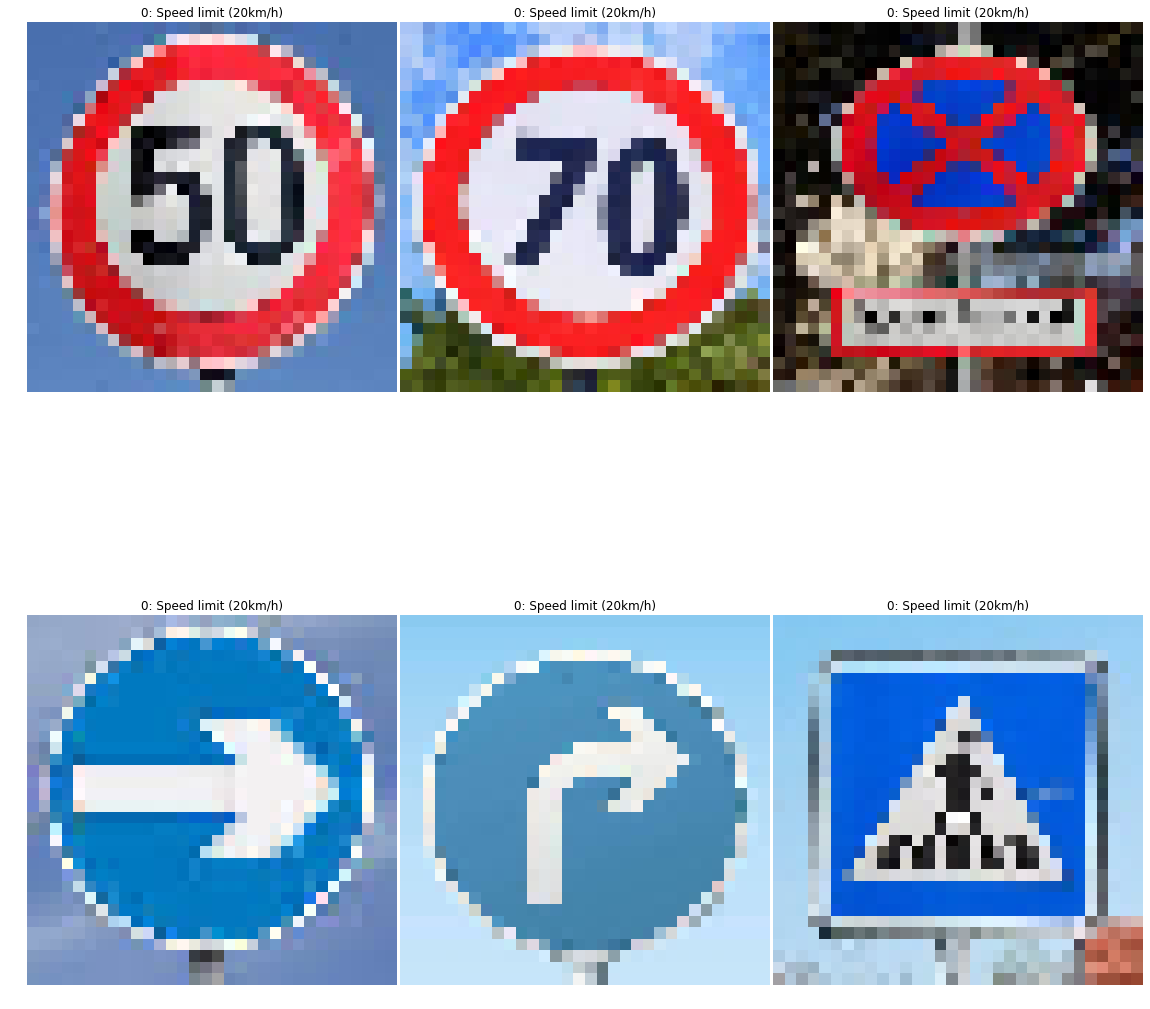

In [40]:
IMAGE_PATHS = [
    "max-50.jpeg",
    "max-70.jpeg",
    "no-stopping.jpeg",
    "right-only.jpeg",
    "right-turn-only.jpg",
    "pedestrians.jpg"
]
LABELS = [0, 0, 0, 0, 0, 0]
downloaded_images = [utils.read_image_for_lenet('./data/traffic-signs-from-internet/' + p) for p in IMAGE_PATHS]

labels = ['{}: {}'.format(l, utils.to_sign_label(l)) for l in LABELS]
utils.plot_and_save(downloaded_images, labels, './docs/images/images-from-internet-resized.jpg', 3)

### Predict the Sign Type for Each Image

In [46]:
d_x = np.stack(downloaded_images)
d_y = np.array(labels)

from_internet = loading.DataSet('From Internet', d_x, d_y, len(d_x))
print(utils.get_summary([from_internet]))
from_internet = preprocessing.PreProcessor.apply(from_internet, PRE_PROCESSORS)


softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./data/model/lenet.meta')
    saver2.restore(sess, "./data/model/lenet")
    
    my_softmax_logits = sess.run(logits, feed_dict={x: d_train.X, mode: Mode.PREDICTING.value})
    

#     my_accuracy = evaluate(my_images_normalized, my_labels)
#     print("Test Set Accuracy = {:.3f}".format(my_accuracy))

{'total-no-of-classes': 2, 'From Internet': {'no-of-classes': 2, 'image-shape': (32, 32, 3), 'number-of-examples': 6}}
2019-03-08 15:29:11 INFO     Running TO_GRAY_SCALE on From Internet dataset...
2019-03-08 15:29:11 INFO     Running TO_GRAY_SCALE on From Internet dataset...
2019-03-08 15:29:11 INFO     Running TO_GRAY_SCALE on From Internet dataset...
2019-03-08 15:29:11 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-08 15:29:11 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-08 15:29:11 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-08 15:29:11 INFO     Running Z_NORMALISATION on From Internet dataset...
2019-03-08 15:29:11 INFO     Running Z_NORMALISATION on From Internet dataset...
2019-03-08 15:29:11 INFO     Running Z_NORMALISATION on From Internet dataset...
2019-03-08 15:29:11 INFO     	Parameters: null
2019-03-08 15:29:11 INFO     	Parameters: null
2019-03-08 15:29:11 INFO     	Parameters: null
2019-

KeyboardInterrupt: 

### Analyze performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.